# Erkennung von Bienen am Ausgang des Bienenstocks

### Global Configuration Settings

In [1]:
config = dict(
    tag_pixel_diameter=50,
    n_frames=None,
    confidence_filter_detections=0.08,
    confidence_filter_tracks=0.20,
    coordinate_scale=1.0,
    start_time=None,
    fps=10.0,
    cam_id=0,
    videos_dir = "../videos/videos_tags/",
    left_leaving_area = 0.3, # Prozente vom Bildschirmrand, zB. bei 1000px und 0.15 -> 0-150px
    right_leaving_area = 0.3,
    px_x_resolution_vid = 1944,
    px_y_resolution_vid = 388,
    localizer_threshold="0.50"
)

### Import all libraries

In [2]:

%env KERAS_BACKEND=theano
%env THEANO_FLAGS=floatX=float32,device=cpu

%load_ext autoreload
%autoreload 1
%aimport bb_behavior
%aimport bb_behavior.plot
%aimport bb_behavior.tracking
%aimport bb_behavior.tracking.pipeline

import bb_behavior
import bb_behavior.plot
import bb_behavior.tracking
import bb_behavior.tracking.pipeline

import time
import datetime

import os
import glob

from tqdm import tqdm_notebook # progress bar

import sys
import math
from math import pi
import numpy as np
import pandas as pd

from itertools import chain, combinations
import random

from bb_tracking.data.constants import DETKEY
#from bb_tracking.tracking import score_id_sim_v
from bb_tracking.tracking import distance_orientations_v, distance_positions_v
from bb_behavior.tracking.pipeline import detect_markers_in_video
from bb_behavior.tracking.pipeline import track_detections_dataframe
from bb_behavior.tracking.pipeline import display_tracking_results
from bb_behavior.tracking.pipeline import get_default_pipeline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import normalize as sklearn_normalize

import matplotlib.pyplot as plt


env: KERAS_BACKEND=theano
env: THEANO_FLAGS=floatX=float32,device=cpu


Using Theano backend.
/home/tscho/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Helper Functions

In [3]:
def filename_to_datestring(filname):
    """
    filename can be path
    """
    return os.path.split(filname)[-1].split('.')[0].split('_')[1]

def datestring_to_filename(datestring, prefix="e00_"):
    return config["videos_dir"] + prefix + datestring + ".h264"

def string_to_timestamp(datestring):
    """ 
    params
        string: format 2018-08-19-01-08-13
    output
        unix timestamp (float)
    """
    
    return time.mktime(time.strptime(datestring, "%Y-%m-%d-%H-%M-%S"))

def timestamp_to_string(timestamp):
    return time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime(timestamp))

# get all videos between timestamp_in and timestamp_out
def get_videos_between(timestamp_in, timestamp_out, all_paths):
    """ returns all video between timestamp_in and timestamp out (inclusive) """
    
    mask = (all_paths['video'] >= timestamp_in) & (all_paths['video'] <= timestamp_out)
    return list(all_paths[mask]['video'])

def loadGTD(path):
    # read in the test data csv
    test_data = pd.read_csv(path)

    # convert the full filenames to string timestamps, and sort by timestamp_in
    test_data['video'] = test_data['video'].apply(lambda x: filename_to_datestring(x))
    test_data['video_start_time'] = test_data['timestamp_in'].apply(lambda x: filename_to_datestring(x))
    test_data['video_end_time'] = test_data['timestamp_out'].apply(lambda x: filename_to_datestring(x))
    test_data.sort_values(['video_start_time'], inplace=True)

    test_data.drop('timestamp_in', 1, inplace=True)
    test_data.drop('timestamp_out', 1, inplace=True)
    test_data.drop('video', 1, inplace=True)
    return test_data

# 1. Detect Tracks

In [4]:
default_pipeline = None
default_pipeline = get_default_pipeline(localizer_threshold=config["localizer_threshold"])

def detect_tracks(paths, save_to_csv = False):
    # Hier passiert das eigentliche Tracken und speichern der Ergebnisse:
    num_processed_videos = 0
    video_data = dict()
    frame_info = None
    detections = None
    bad_paths = []

    for path in tqdm_notebook(paths):
        start_time = config["start_time"]
        cam_id = config["cam_id"]
        try:
            num_processed_videos += 1

            frame_info, detections = detect_markers_in_video(path,
                                                          decoder_pipeline=default_pipeline,#pipeline=pipelines(),
                                                         tag_pixel_diameter=config["tag_pixel_diameter"],
                                                          n_frames=config["n_frames"],
                                                          fps=config["fps"],
                                                         progress="tqdm_notebook"
                                                )
            # Sonst würden keine Tracks erkannt werden -> Fehlermeldung
            if len(detections[detections['confidence']>=config["confidence_filter_detections"]]) == 0:
                continue
            tracks = track_detections_dataframe(detections,
                                                tracker="tracker.det_score_fun.frag_score_fun.dill",
                                                confidence_filter_detections=config["confidence_filter_detections"],
                                               confidence_filter_tracks=config["confidence_filter_tracks"],
                                                coordinate_scale=config["coordinate_scale"],
                                               )
            date_string = filename_to_datestring(path)
            tracks['video'] = date_string
            video_data[path] = (frame_info, detections, tracks)
        except ValueError as err: #tritt auf, wenn Video leer ist. In diesem Fall: überspringe video
            try:
                bad_paths.append(path)
                # wir arbeiten später nochmal mit paths, daher müssen das leere löschen, weil sonst
                # in video_data kein zugehöriger Value zu Key = file zu finden ist.
            except KeyError as err:
                continue
        except Exception as err:
            print(err)
            raise
        # only first vid: break

    for bad_path in bad_paths:
        paths.remove(bad_path)

    #video_data["file"][0] --> frame-info, [1] --> detections, [2] --> tracks
    for path in paths:
        display_tracking_results(path, video_data[path][0], video_data[path][1], video_data[path][2])

    tracks = [video_data[paths[x]][2] for x in range(len(paths))]
    tracks = pd.concat(tracks,ignore_index=True)
    tracks = tracks.drop(columns=["localizerSaliency", "beeID", "camID", "frameIdx"])

    if save_to_csv:
        with open("tracks.csv", "w") as f:
            tracks.to_csv(f)

    return tracks

/home/tscho/.local/lib/python3.6/site-packages/keras/backend/theano_backend.py:1032: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/tscho/.local/lib/python3.6/site-packages/keras/backend/theano_backend.py:1032: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/tscho/.local/lib/python3.6/site-packages/keras/backend/theano_backend.py:1032: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


## 1.1 Create video path list from all videos in videos_dir

In [5]:
# Einen Iterable speichern, der alle Videos in einem Iterable zur Verfügung stellt
# Diesen Iterable können wir dann in der nächsten Zelle mit tqdm schön durchlaufen
base_directory = config["videos_dir"]
paths = [i for i in os.listdir(base_directory) if i.endswith(".h264")]
for i in range(len(paths)):
    paths[i] = base_directory + paths[i]

## 1.2 Create video path list from test set

In [6]:
# read in the test data csv
test_data = loadGTD("bees_test.csv")

all_videos = []

all_paths = pd.DataFrame(glob.glob(os.path.join(config["videos_dir"], '*.h264')), columns=['video'])
all_paths['video'] = all_paths['video'].apply(lambda x: filename_to_datestring(x))
all_paths.sort_values(['video'])

# go through test_data and get all videos between timestamp_in and timestamp_out
for index, row in test_data.iterrows():
    all_videos += get_videos_between(row['video_start_time'],row['video_end_time'], all_paths)
    
all_videos = sorted(list(set(all_videos)))
paths = [datestring_to_filename(x) for x in all_videos]
del all_paths
del test_data

## 1.3 Run Detection Pipeline

# 2. Data Preprocessing

In [7]:
# load the data from tracking step
tracks = pd.read_csv("all_tracks.csv", index_col=0)
tracks.head()

,id,xpos,ypos,zrotation,timestamp,confidence,track_id,track_confidence,bee_id,video
0,f16454994143232751227d0c0,477.180838,164.151279,0.270257,8.1,0.183379,0.0,0.831785,433.0,2018-08-19-08-21-08
1,f16578218940730512316d0c0,564.704552,151.617500,0.245167,8.2,0.964998,0.0,0.831785,433.0,2018-08-19-08-21-08
2,f17333786135254116214d0c0,640.170750,163.932972,0.335837,8.3,0.325308,0.0,0.831785,433.0,2018-08-19-08-21-08
3,f17914062438408532176d0c0,712.797358,189.150818,0.458709,8.4,0.994973,0.0,0.831785,433.0,2018-08-19-08-21-08
4,f12965964851209682910d0c0,788.526833,201.583246,0.462691,8.5,0.980744,0.0,0.831785,433.0,2018-08-19-08-21-08


## 2.1 Convert Tracks format

In [8]:
def gather_tracks(tracks):
    """
    transform the tracks df to : bee_id, [list of positions (x,y)], [list of timestamps], timestamp_of video
    """

    #  transform tracks df to : bee_id, [list of positions (x,y)], [list of timestamps], timestamp_of video
    grouped = tracks.groupby(['bee_id','track_id','video'],  as_index=False)['xpos','ypos','timestamp','zrotation']

    tracks_ml = grouped.aggregate(lambda x: list(x))

    # we don't need track_id anymore
    tracks_ml = tracks_ml.drop('track_id', 1)

    # add a column: convert video name to timestamp
    tracks_ml['video_start_time'] = tracks_ml['video'].apply(lambda x: string_to_timestamp(x))
    
    # we don't need video anymore
    tracks_ml = tracks_ml.drop('video', 1)

    # because aggregated: now multiple timestamps per row: --> rename
    tracks_ml = tracks_ml.rename(columns={'timestamp': 'timestamps'})

    # calculate start time of track by adding timestamp of track (seconds since start of video)
    # to timestamp of video (date)
    tracks_ml['track_start_time'] = tracks_ml['video_start_time'] + tracks_ml['timestamps'].apply(lambda x: x[0])
    tracks_ml['track_end_time'] = tracks_ml['video_start_time'] + tracks_ml['timestamps'].apply(lambda x: x[-1])
    
    # convert back to string
    tracks_ml['video_start_time'] = tracks_ml['video_start_time'].apply(lambda x: timestamp_to_string(x))
    
    all_paths = pd.DataFrame(glob.glob(os.path.join(config["videos_dir"], '*.h264')), columns=['video'])
    all_paths['video'] = all_paths['video'].apply(lambda x: filename_to_datestring(x))
    all_paths.sort_values(['video'])
    # get end video
    tracks_ml['video_end_time'] =  tracks_ml['track_end_time'].apply(lambda x: timestamp_to_string(x))
    tracks_ml['video_end_time'] =  tracks_ml[['video_start_time','video_end_time']].apply(lambda x: get_videos_between(x[0],x[1],all_paths)[-1], axis=1)

    return tracks_ml

## 2.2 Merge Tracks

Merge tracks that span multiple videos, based on time threshold between the track end and next track start time.

In [9]:
def merge_tracks(tracks_ml, time_threshold=10, verbose = False):
    """
    in: 
        tracks_ml: output from gather_tracks(tracks)
    out:
        same df as in, with merged rows
        [bee_id:Float, xpos:[Float], ypos:[Float], zrotation:[Float], timestamps:[Float], video_start_time: String,
        video_end_time: String, track_start_time:Float, track_end_time:Float]
        
    merge tracks of same bee where start and end timestamps are close together
    assume there can not be overlapping tracks
    """
    
    
    # 1. sort: bee_id, start_time
    tracks_ml = tracks_ml.sort_values(['bee_id', 'track_start_time'])

    
    # first convert to timestamp
    tracks_ml['video_start_time'] = tracks_ml['video_start_time'].apply(lambda x: string_to_timestamp(x))
    
    index = 0
    while(True):
        row = tracks_ml.iloc[index]
        next_row = tracks_ml.iloc[index+1]

        # if the tracks are from same bee and the start time of next row is closer then 10s -> merge the rows
        # merge rows means, next_row is deleted
        if (row['bee_id'] == next_row['bee_id']) and ((next_row['track_start_time'] - row['track_end_time']) < time_threshold):
            
            if verbose:
                print(timestamp_to_string(row['video_start_time']), row['bee_id'], next_row['track_start_time'] - row['track_end_time'])
                print(next_row['video_start_time'] - row['video_start_time'])
                print(timestamp_to_string(row['track_start_time']),timestamp_to_string(row['track_end_time']),timestamp_to_string(row['video_start_time']),row['video_end_time'])
                print(row['timestamps'])
                print(row.name)
                print(timestamp_to_string(next_row['track_start_time']))
                print('----------------------------------')
           
            # update the timestamps of nextrow
            t = next_row['video_start_time'] - row['video_start_time']
            timestamps = list( np.array(next_row['timestamps']) + t)

            # merge xpos, ypos, timestamps lists
            tracks_ml.at[row.name,'xpos'] = row['xpos']+next_row['xpos']
            tracks_ml.at[row.name,'ypos'] = row['ypos']+next_row['ypos']
            tracks_ml.at[row.name,'zrotation'] = row['zrotation']+next_row['zrotation']
            tracks_ml.at[row.name,'timestamps'] = row['timestamps']+timestamps

            # update end_time
            tracks_ml.at[row.name,'track_end_time'] = next_row['track_end_time']
            tracks_ml.at[row.name,'video_end_time'] = next_row['video_end_time']

            # delete the merged row (next_row)
            tracks_ml = tracks_ml.drop(next_row.name).copy()
            
            assert(len(tracks_ml.at[row.name,'xpos']) == len(tracks_ml.at[row.name,'xpos']) == len(tracks_ml.at[row.name,'xpos']) == len(tracks_ml.at[row.name,'zrotation']))

        else:
            index += 1
        
        if index == len(tracks_ml) - 1:
            break
            
    # convert back to string
    tracks_ml['video_start_time'] = tracks_ml['video_start_time'].apply(lambda x: timestamp_to_string(x))
            
    return tracks_ml

In [10]:
tracks_ml = gather_tracks(tracks)
l1 = len(tracks_ml)

tracks_ml = merge_tracks(tracks_ml)
l2 = len(tracks_ml)

tracks_ml = tracks_ml.sort_values(['video_start_time'])

In [11]:
print("merged", l1-l2, "of",l1,"tracks")
tracks_ml.head()

merged 66 of 238 tracks


,bee_id,xpos,ypos,timestamps,zrotation,video_start_time,track_start_time,track_end_time,video_end_time
202,1970.0,"[1175.1580028533936, 1275.0042209625246, 1199....","[100.45368194580078, 252.97906684875488, 264.9...","[1.6, 2.3, 2.8, 3.1, 4.0, 4.1, 4.2, 4.3, 4.6, ...","[-1.5437196000000002, 0.18208171, 1.7509313000...",2018-08-19-02-21-37,1.534638e+09,1.534638e+09,2018-08-19-02-22-40
230,3890.0,"[1275.218282699585, 1286.7158908843996]","[164.32666015625, 214.9285774230957]","[9.2, 9.3]","[-0.34192994, 0.24574603]",2018-08-19-02-21-58,1.534638e+09,1.534638e+09,2018-08-19-02-21-58
197,1697.0,"[449.36813163757324, 449.7386884689331, 449.44...","[162.46553993225098, 162.55523109436038, 149.9...","[3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, ...","[-2.1262455, -2.0971236, -2.1020923, -2.002343...",2018-08-19-02-22-40,1.534638e+09,1.534638e+09,2018-08-19-02-22-40
1,220.0,"[587.6349468231201, 577.2753982543945, 589.496...","[123.45260810852051, 125.9588794708252, 138.67...","[0.4, 14.0, 14.1, 14.2, 14.3, 14.4, 14.5, 14.6...","[-2.787043, 0.020939333, -0.15247042, 0.053603...",2018-08-19-05-25-51,1.534649e+09,1.534649e+09,2018-08-19-05-25-51
228,3692.0,"[1125.3886528015137, 1075.4727592468264, 1013....","[263.25339698791504, 224.84710693359372, 212.8...","[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.3]","[2.9821217, 2.9418721000000003, 2.897287, 3.08...",2018-08-19-06-35-41,1.534653e+09,1.534653e+09,2018-08-19-06-35-41


## 2.3 Add labels to tracks data

In [12]:
# read in the test data csv (the manually labeled data)
test_data = loadGTD("bees_test.csv")
test_data.drop_duplicates(inplace=True)
test_data.head()

,bee_id,in_direction,out_direction,video_start_time,video_end_time
102,1970,left,left,2018-08-19-02-21-37,2018-08-19-02-22-40
0,855,right,left,2018-08-19-05-25-51,2018-08-19-05-25-51
1,220,left,right,2018-08-19-05-25-51,2018-08-19-05-25-51
24,8692,left,right,2018-08-19-06-35-41,2018-08-19-06-35-41
106,1191,right,left,2018-08-19-07-10-38,2018-08-19-07-10-38


In [13]:
# get all tracks where bee_id, video_start_time and video_end_time are the same
tracks_ml = pd.merge(tracks_ml,test_data,how='inner',on=['bee_id','video_start_time','video_end_time'])

print(len(tracks_ml))
tracks_ml.head()

62


,bee_id,xpos,ypos,timestamps,zrotation,video_start_time,track_start_time,track_end_time,video_end_time,in_direction,out_direction
0,1970.0,"[1175.1580028533936, 1275.0042209625246, 1199....","[100.45368194580078, 252.97906684875488, 264.9...","[1.6, 2.3, 2.8, 3.1, 4.0, 4.1, 4.2, 4.3, 4.6, ...","[-1.5437196000000002, 0.18208171, 1.7509313000...",2018-08-19-02-21-37,1.534638e+09,1.534638e+09,2018-08-19-02-22-40,left,left
1,220.0,"[587.6349468231201, 577.2753982543945, 589.496...","[123.45260810852051, 125.9588794708252, 138.67...","[0.4, 14.0, 14.1, 14.2, 14.3, 14.4, 14.5, 14.6...","[-2.787043, 0.020939333, -0.15247042, 0.053603...",2018-08-19-05-25-51,1.534649e+09,1.534649e+09,2018-08-19-05-25-51,left,right
2,3925.0,"[538.5966873168945, 588.3075313568115, 651.012...","[126.37010765075684, 126.80798149108887, 127.0...","[11.9, 12.0, 12.1, 12.2, 12.3, 12.4, 12.5, 12.6]","[-0.48655950000000003, -0.23565856, -0.0598887...",2018-08-19-07-47-52,1.534658e+09,1.534658e+09,2018-08-19-07-47-52,left,right
3,388.0,"[1375.2675552368164, 1313.4858207702634, 1225....","[239.0948257446289, 238.7294406890869, 237.849...","[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]","[2.9390156000000003, 2.9522842999999996, -2.97...",2018-08-19-08-29-06,1.534660e+09,1.534660e+09,2018-08-19-08-29-06,right,left
4,1066.0,"[1413.0752410888672, 1350.3371124267578, 1325....","[251.15822410583496, 238.2443084716797, 188.21...","[1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, ...","[2.8809676, 3.0900168, -2.7678201000000002, -3...",2018-08-19-09-28-45,1.534664e+09,1.534664e+09,2018-08-19-09-28-45,right,left


# Interlude: Accuracy of Tracking

In [14]:
test_data_len = len(test_data)

# get the total number of tracks where the start_video and bee_id is correct
correct_in_video_start = len(pd.merge(tracks_ml,test_data[['bee_id','in_direction','video_start_time']], on=['bee_id','video_start_time'], how='inner'))

# get the total number of tracks where the end video and bee_id is correct
correct_in_video_end = len(pd.merge(tracks_ml,test_data[['bee_id','out_direction','video_end_time']], on=['bee_id','video_end_time'], how='inner'))

# get all tracks where bee_id, video_start_time and video_end_time are the same
total_correct = len(pd.merge(tracks_ml,test_data[['bee_id','in_direction','out_direction','video_end_time','video_start_time']], how='inner',on=['bee_id','video_start_time','video_end_time']))

print('bee_id and video_start_time correct: %.2f (%d/%d)' % (correct_in_video_start/test_data_len,correct_in_video_start,test_data_len))
print('bee_id and video_end_time correct: %.2f (%d/%d)' % (correct_in_video_end/test_data_len,correct_in_video_end,test_data_len))
print('bee_ids and both videos correct: %.2f (%d/%d)' % (total_correct/test_data_len,total_correct,test_data_len))

bee_id and video_start_time correct: 0.62 (64/104)
bee_id and video_end_time correct: 0.62 (64/104)
bee_ids and both videos correct: 0.62 (64/104)


## 2.4 Data Augmentation

Optional: Tracks um 180° drehen; Tracks horizontal invertieren; Tracks vertikal invertieren (Funktioniert, abhängig von der Wichtigkeit der Zeit als Feature, vielleicht nicht!)

In [15]:
def inc_year(video_time_string):
    video_string_parts = video_time_string.split('-')
    video_string_parts[0] = str(int(video_string_parts[0]) + 1)
    return '-'.join(video_string_parts)

def opposite(direction):
            if direction == 'left':
                return 'right'
            else:
                return 'left'

"""
invertiert einen Track auf der vertikalen Achse. Bei outer ist die Achse die Achse des Videos.
"""
def invertVertical_outer(tracks_ml):
    inverted_tracks = tracks_ml.copy(deep = True)
    center = config['px_y_resolution_vid']/2 #default
    for index, row in tracks_ml.iterrows():
        inverted_tracks.at[index, 'ypos'] = [abs(y - center) for y in row['ypos']]
        inverted_tracks.at[index, 'zrotation'] = [z * -1 for z in row['zrotation']]
        inverted_tracks.at[index, 'video_start_time'] = inc_year(row['video_start_time'])
        inverted_tracks.at[index, 'track_start_time'] = string_to_timestamp(row['video_start_time']) + row['timestamps'][0]
        inverted_tracks.at[index, 'track_end_time'] = string_to_timestamp(row['video_start_time']) + row['timestamps'][-1]
        inverted_tracks.at[index, 'video_end_time'] = inc_year(row['video_end_time'])
    return inverted_tracks

"""
invertiert einen Track auf der vertikalen Achse. Bei inner ist die Achse die Achse des Trackbereichs.
"""
def invertVertical_inner(tracks_ml):
    inverted_tracks = tracks_ml.copy(deep = True)
    for index, row in tracks_ml.iterrows():
        center = max(row['ypos']) - (min(row['ypos'])/2)
        inverted_tracks.at[index, 'ypos'] = [abs(y - center) for y in row['ypos']]
        inverted_tracks.at[index, 'zrotation'] = [z * -1 for z in row['zrotation']]
        inverted_tracks.at[index, 'video_start_time'] = inc_year(row['video_start_time'])
        inverted_tracks.at[index, 'track_start_time'] = string_to_timestamp(row['video_start_time']) + row['timestamps'][0]
        inverted_tracks.at[index, 'track_end_time'] = string_to_timestamp(row['video_start_time']) + row['timestamps'][-1]
        inverted_tracks.at[index, 'video_end_time'] = inc_year(row['video_end_time'])
    return inverted_tracks

def invertHorizontal(tracks_ml):
    inverted_tracks = tracks_ml.copy(deep = True)
    for index, row in tracks_ml.iterrows():
        center = max(row['xpos']) - (min(row['xpos'])/2)
        inverted_tracks.at[index, 'xpos'] = [abs(x - center) for x in row['xpos']]
        
        def zrotation_shifter(z):
            cmp = pi/2
            if z >= cmp:
                return z - cmp
            else:
                return z + cmp

        inverted_tracks.at[index, 'zrotation'] = [zrotation_shifter(z) for z in row['zrotation']]
        inverted_tracks.at[index, 'video_start_time'] = inc_year(row['video_start_time'])
        inverted_tracks.at[index, 'track_start_time'] = string_to_timestamp(row['video_start_time']) + row['timestamps'][0]
        inverted_tracks.at[index, 'track_end_time'] = string_to_timestamp(row['video_start_time']) + row['timestamps'][-1]
        inverted_tracks.at[index, 'video_end_time'] = inc_year(row['video_end_time'])
        inverted_tracks.at[index, 'in_direction'] = opposite(row['in_direction'])
        inverted_tracks.at[index, 'out_direction'] = opposite(row['out_direction'])
    return inverted_tracks

"""
randomisiert y Koordinaten
"""
def randomize_y_coordinates(tracks_ml):
    threshold_y = 0.02 # Looking at the original videos, 2% equate to about 7px on the y-axis
    inverted_tracks = tracks_ml.copy(deep = True)
    for index, row in tracks_ml.iterrows():
        lower_bound = -(config['px_y_resolution_vid'] * threshold_y)
        upper_bound = config['px_y_resolution_vid'] * threshold_y
        inverted_tracks.at[index, 'ypos'] = [y + random.uniform(lower_bound, upper_bound) for y in row['ypos']]
        inverted_tracks.at[index, 'video_start_time'] = inc_year(row['video_start_time'])
        inverted_tracks.at[index, 'track_start_time'] = string_to_timestamp(row['video_start_time']) + row['timestamps'][0]
        inverted_tracks.at[index, 'track_end_time'] = string_to_timestamp(row['video_start_time']) + row['timestamps'][-1]
        inverted_tracks.at[index, 'video_end_time'] = inc_year(row['video_end_time'])
    return inverted_tracks
    
"""
randomisiert x Koordinaten
"""
def randomize_x_coordinates(tracks_ml):
    threshold_x = 0.01 # equates to 19 px
    inverted_tracks = tracks_ml.copy(deep = True)
    for index, row in tracks_ml.iterrows():
        lower_bound = - config['px_x_resolution_vid'] * threshold_x
        upper_bound = config['px_x_resolution_vid'] * threshold_x
        inverted_tracks.at[index, 'xpos'] = [x + random.uniform(lower_bound, upper_bound) for x in row['xpos']]
        inverted_tracks.at[index, 'video_start_time'] = inc_year(row['video_start_time'])
        inverted_tracks.at[index, 'track_start_time'] = string_to_timestamp(row['video_start_time']) + row['timestamps'][0]
        inverted_tracks.at[index, 'track_end_time'] = string_to_timestamp(row['video_start_time']) + row['timestamps'][-1]
        inverted_tracks.at[index, 'video_end_time'] = inc_year(row['video_end_time'])
    return inverted_tracks

#
# Biene geht andersherum -> koordinaten vertauschen, labels vertauschen
#
def reverse_path(tracks_ml):
    reversed_tracks = tracks_ml.copy(deep = True)
    for index, row in tracks_ml.iterrows():
        reversed_tracks.at[index, 'xpos'] = list(reversed(row['xpos']))
        reversed_tracks.at[index, 'ypos'] = list(reversed(row['ypos']))
        reversed_tracks.at[index, 'video_start_time'] = inc_year(row['video_start_time'])
        reversed_tracks.at[index, 'track_start_time'] = string_to_timestamp(row['video_start_time']) + row['timestamps'][0]
        reversed_tracks.at[index, 'track_end_time'] = string_to_timestamp(row['video_start_time']) + row['timestamps'][-1]
        reversed_tracks.at[index, 'video_end_time'] = inc_year(row['video_end_time'])
        reversed_tracks.at[index, 'in_direction'] = opposite(row['in_direction'])
        reversed_tracks.at[index, 'out_direction'] = opposite(row['out_direction'])
    return reversed_tracks

"""
Using powerset on a list of functions to try all possibilities
param: DataFrame containing the standardized columns
return: new DataFrame, containing also the original
"""
def augment_data(tracks_ml):
    # taken from https://docs.python.org/3/library/itertools.html#recipes
    # and slightly modified
    def powerset(iterable):
        "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
        s = list(iterable)
        return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))
    functions = [invertVertical_outer, invertVertical_inner, invertHorizontal,
                 randomize_y_coordinates, randomize_x_coordinates, reverse_path]
    powerset = powerset(functions)
    length_powerset = 2**(len(functions))
    result = tracks_ml
    for i in range(length_powerset):
        newDataFrame = tracks_ml.copy(deep = True)
        for f in powerset[i]:
            newDataFrame = f(newDataFrame)
        result = result.append(newDataFrame, ignore_index = True)
    return result


## 2.5 Get Features from data

In [16]:
# helper functions

def normalize(x, min_x, max_x):
    """ normalize x to 0..1 """
    return (x-min_x)/(max_x-min_x)

def get_time_from_timestamp(timestamp):
    """ return time of day in hours (float) (range 0-23.99) """
    time_struct = time.localtime(timestamp)
    return time_struct.tm_hour+normalize(time_struct.tm_min, 0, 60)

def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1-p2)**2))

def get_speed(p1, p2, t1, t2):
    d = euclidean_distance(p1, p2)
    t = t2-t1
    return d/t

def get_start_speed(xpos, ypos, timestamps):
    
    assert(len(xpos) == len(ypos) == len(timestamps))
    
    if len(xpos) < 2:
        return 0
    p1 = np.array([xpos[0], ypos[0]])
    p2 = np.array([xpos[1], ypos[1]])
    
    return get_speed(p1,p2,timestamps[0],timestamps[1])

def get_end_speed(xpos, ypos, timestamps):
    
    assert(len(xpos) == len(ypos) == len(timestamps))
    
    if len(xpos) < 2:
        return 0
    
    p1 = np.array([xpos[-2], ypos[-2]])
    p2 = np.array([xpos[-1], ypos[-1]])
    return get_speed(p1,p2,timestamps[-2],timestamps[-1])

def get_avg_speed(xpos, ypos, timestamps):
    """ returns a list of speeds between the points (x_pos, y_pos) """
    if len(xpos) <= 1:
        return 0
    
    s = []
    for i in range(len(xpos)-1):
        p1 = np.array([xpos[i], ypos[i]])
        p2 = np.array([xpos[i+1], ypos[i+1]])
        
        speed = get_speed(p1, p2, timestamps[i], timestamps[i+1])
        s.append(speed)
        
    s = np.array(s)
    return np.mean(s)

def get_track_distance(xpos, ypos):
    points = np.array([xpos, ypos]).T
    
    dists = []
    for i in range(points.shape[0]-1):
        d = euclidean_distance(points[i],points[i+1])
        dists.append(d)
    return np.sum(dists)

In [17]:

def get_features(X, include=None, exclude=None, normalize=False):
    """ 
    if include != None then only include features in include array, ignore exclude. default: include all
    if exclude != None then inlcude all except exclude array. default: exclude None
    
    if normalize = True, normalizes all features to range [0,1]
    
    'duration',
    'day_time',
    'num_detections',
    'start_xpos',
    'end_xpos',
    'avg_xpos',
    'start_ypos',
    'end_ypos',
    'start_z_rotation',
    'end_z_rotation',
    'avg_zrotation',
    'start_speed',
    'end_speed',
    'avg_speed',
    'track_length'
    """
    
    # duration, start_pos, end_pos, start_z_rotation, end_z_rotation, time_of_day, num_points_in_track, avg_speed_of_bee, start_speed, end_speed
    tracks = X.copy()
    tracks_features = X.copy()
    
    tracks_features['duration'] = tracks['track_end_time'] - tracks['track_start_time']
    tracks_features['start_xpos'] = tracks['xpos'].apply(lambda x: x[0])
    tracks_features['end_xpos'] = tracks['xpos'].apply(lambda x: x[-1])
    tracks_features['avg_xpos'] = tracks['xpos'].apply(lambda x: np.mean(x))
    tracks_features['start_ypos'] = tracks['ypos'].apply(lambda x: x[0]) # do we need?
    tracks_features['end_ypos'] = tracks['ypos'].apply(lambda x: x[-1]) # do we need?


    tracks_features['normalized_zrotation'] =  tracks['zrotation'].apply(lambda x: np.abs(x)) #lambda x: np.array(x) + math.pi) # we normalized because pi -pi
    tracks_features['start_z_rotation'] = tracks_features['normalized_zrotation'].apply(lambda x: x[0])
    tracks_features['end_z_rotation'] = tracks_features['normalized_zrotation'].apply(lambda x: x[-1])
    tracks_features['avg_zrotation'] =  tracks_features['normalized_zrotation'].apply(lambda x: np.mean(x))

    tracks_features['day_time'] = (tracks['track_start_time'] + tracks['track_end_time']) / 2
    tracks_features['day_time'] = tracks_features['day_time'].apply(lambda x: get_time_from_timestamp(x))

    tracks_features['num_detections'] = tracks['xpos'].apply(lambda x: len(x))

    # speed
    tracks_features['start_speed'] = tracks[['xpos','ypos','timestamps']].apply(lambda x: get_start_speed(x[0],x[1],x[2]), axis=1)
    tracks_features['end_speed'] = tracks[['xpos','ypos','timestamps']].apply(lambda x: get_end_speed(x[0],x[1],x[2]), axis=1)
    tracks_features['avg_speed'] = tracks[['xpos','ypos','timestamps']].apply(lambda x: get_avg_speed(x[0],x[1],x[2]), axis=1)

    # total distance traveled
    tracks_features['track_length'] = tracks[['xpos','ypos']].apply(lambda x: get_track_distance(x[0],x[1]), axis=1)
    
    #must_include = ['bee_id','video_start_time','video_end_time','track_start_time','track_end_time','in_direction','out_direction']
    all_features = ['duration','day_time','num_detections','start_xpos','end_xpos','avg_xpos','start_ypos','end_ypos','start_z_rotation','end_z_rotation','avg_zrotation','start_speed','end_speed','avg_speed', 'track_length']
    if include is None and exclude is None:
        columns = all_features
    if include is not None:
        columns = include
    if exclude is not None:
        columns = [x for x in all_features if x not in exclude]
        
    tracks_features = tracks_features[columns]
    
    if normalize is True:
        
        tracks_features = pd.DataFrame(sklearn_normalize(tracks_features, axis=0), columns=tracks_features.columns)
        
    return tracks_features

In [18]:
X = get_features(tracks_ml, normalize=True)
X.head()

,duration,day_time,num_detections,start_xpos,end_xpos,avg_xpos,start_ypos,end_ypos,start_z_rotation,end_z_rotation,avg_zrotation,start_speed,end_speed,avg_speed,track_length
0,0.470916,0.021084,0.187864,0.172225,0.077720,0.117777,0.068760,0.152675,0.108949,0.132789,0.113309,0.062576,0.061013,0.064216,0.440940
1,0.113805,0.048405,0.044341,0.086121,0.172843,0.144013,0.084503,0.074075,0.196697,0.008528,0.026960,0.000188,0.096853,0.067116,0.048993
2,0.004578,0.069489,0.009335,0.078934,0.128357,0.112585,0.086500,0.066243,0.034339,0.009942,0.012826,0.119450,0.160834,0.166270,0.022548
3,0.005232,0.075577,0.010502,0.201552,0.082480,0.152650,0.163660,0.160679,0.207422,0.182683,0.240867,0.148452,0.169267,0.221510,0.034331
4,0.007849,0.084338,0.014002,0.207093,0.077721,0.155141,0.171918,0.080035,0.203326,0.181526,0.237745,0.153908,0.218699,0.179489,0.040611


# Interlude: Feature selection

In [19]:
# select features based on https://scikit-learn.org/stable/modules/feature_selection.html

print("\n--- In-Direction ---")
y = tracks_ml['in_direction']

selector = SelectKBest(chi2, k=5)
selector.fit(X, y)

# Get columns to keep
cols = selector.get_support(indices=True)

print("Important Columns chi2:",list(X.columns[cols]))

selector = SelectKBest(f_classif, k=5)
selector.fit(X, y)
cols = selector.get_support(indices=True)

print("Important Columns f_classif:",list(X.columns[cols]))

selector = SelectKBest(mutual_info_classif, k=5)
selector.fit(X, y)
cols = selector.get_support(indices=True)

print("Important Columns mutual info:",list(X.columns[cols]))

print("\n\n--- Out-Direction ---")
y = tracks_ml['out_direction']

selector = SelectKBest(chi2, k=5)
selector.fit(X, y)

# Get columns to keep
cols = selector.get_support(indices=True)

print("Important Columns chi2:",list(X.columns[cols]))

selector = SelectKBest(f_classif, k=5)
selector.fit(X, y)
cols = selector.get_support(indices=True)

print("Important Columns f_classif:",list(X.columns[cols]))

selector = SelectKBest(mutual_info_classif, k=5)
selector.fit(X, y)
cols = selector.get_support(indices=True)

print("Important Columns mutual info:",list(X.columns[cols]))


--- In-Direction ---
Important Columns chi2: ['start_xpos', 'start_z_rotation', 'end_z_rotation', 'avg_zrotation', 'start_speed']
Important Columns f_classif: ['start_xpos', 'start_ypos', 'start_z_rotation', 'end_z_rotation', 'avg_zrotation']
Important Columns mutual info: ['start_xpos', 'start_ypos', 'start_z_rotation', 'avg_zrotation', 'start_speed']


--- Out-Direction ---
Important Columns chi2: ['start_xpos', 'end_xpos', 'start_z_rotation', 'end_z_rotation', 'avg_zrotation']
Important Columns f_classif: ['start_xpos', 'end_xpos', 'start_z_rotation', 'end_z_rotation', 'avg_zrotation']
Important Columns mutual info: ['day_time', 'end_xpos', 'end_ypos', 'end_z_rotation', 'avg_zrotation']


/home/tscho/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
/home/tscho/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


# 3. Classifiers

## 3.1 Baseline - Areas as Decider

In [20]:
class baseline_area_clf():
    """ Vorgehen:
    Für jedes Bienen-Track Paar
    - Prüfe, wo sich die Biene beim ersten erkannten Erscheinen aufhält
        - Ordne die Position in left, right oder middle ein
    - Prüfe, wo sich die Biene beim letzten erkannten Erscheinen aufhält
        - Ordne die Position in left, right oder middle ein
    Wenn sich Biene in der Mitte befindet, starte neue Routine, die links oder rechts zuordnet
    Daraus kann nun abgeleitet werden, wo die Biene reingekommen ist und wo sie rausgegangen ist.
    """

    def __init__(self, verbose=True, area_percentage=0.30, total_area = 1944):
        
        self.verbose = verbose
        self.area_percentage = area_percentage
        self.total_area = total_area

    def fit(self, train_x, train_y):
        return self

    def test(self, test_x, test_y):
        
        pred_y = self.predict(test_x)
        
        return classifier_metrics(test_y, pred_y, verbose=self.verbose)
        
    def predict(self, x):
        
        #print(x.head())

        pred_y = pd.DataFrame(columns=['pred_in_direction','pred_out_direction'])
        pred_y['pred_in_direction'] = x[['start_xpos','start_z_rotation']].apply(lambda x1: self._get_direction(x1[0],x1[1]), axis = 1)
        pred_y['pred_out_direction'] = x[['end_xpos','end_z_rotation']].apply(lambda x1: self._get_direction(x1[0],x1[1]), axis = 1)
        
        return pred_y
        
    def _get_direction(self, xpos, zrotation):
            
        # Eintrittsseite festlegen
        if xpos <= self.area_percentage*self.total_area:
            return "left"
        elif xpos >= self.total_area - self.area_percentage*self.total_area:
            return "right"
        else:
            if abs(zrotation) > pi/2:
                return "left"
            else:
                return "right"

## 3.2 Baseline - zpos as decider

In [21]:
class baseline_zrotation_clf():
    """ Vorgehen:
    Unterschied: Hier wird nicht auf die Position abgestellt, sondern ausschließlich auf die
    Richtung, in die die Biene schaut
    """

    def __init__(self, verbose=True):
        
        self.verbose = verbose

    def fit(self, train_x, train_y):
        return self

    def test(self, test_x, test_y):
        
        pred_y = self.predict(test_x)
        
        return classifier_metrics(test_y, pred_y, verbose=self.verbose)
        
    def predict(self, x):
        
        pred_y = pd.DataFrame(columns=['pred_in_direction','pred_out_direction'])
        pred_y['pred_in_direction'] = x['start_z_rotation'].apply(lambda x1: 'left' if x1 < math.pi/2 else 'right')
        pred_y['pred_out_direction'] = x['end_z_rotation'].apply(lambda x1: 'right' if x1 < math.pi/2 else 'left')
        
        return pred_y

## 3.3 Logistische Regression

In [22]:
class logisic_regression_clf():

    def __init__(self, k_features=1, feature_selection_method="mutual_info_classif", normalized=False, verbose=True):
        
        self.k_features = k_features
        self.feature_selection_method = feature_selection_method
        self.normalized = normalized
        self.verbose = verbose

    def fit(self, train_x, train_y):

        self.features_in_dir = train_x.columns
        self.features_out_dir = train_x.columns

        if self.k_features is not None:
            selector_in_dir = SelectKBest(
                mutual_info_classif, k=self.k_features) if self.feature_selection_method == "mutual_info_classif" else SelectKBest(f_classif, k=self.k_features)
            selector_in_dir.fit(train_x, train_y['in_direction'])
            self.features_in_dir = train_x.columns[selector_in_dir.get_support(
                indices=True)]
            if self.verbose:
                print('Selected Features for in_direction:', self.features_in_dir)

            selector_out_dir = SelectKBest(
                mutual_info_classif, k=self.k_features) if self.feature_selection_method == "mutual_info_classif" else SelectKBest(f_classif, k=self.k_features)
            selector_out_dir.fit(train_x, train_y['out_direction'])
            self.features_out_dir = train_x.columns[selector_out_dir.get_support(
                indices=True)]
            if self.verbose:
                print('Selected Features for out_direction:', self.features_out_dir)

        train_x_in = train_x[self.features_in_dir]
        train_x_out = train_x[self.features_out_dir]

        # in_dir
        self.clf_in = LogisticRegression()
        self.clf_in.fit(train_x_in, train_y['in_direction'])

        # out_dir
        self.clf_out = LogisticRegression()
        self.clf_out.fit(train_x_out, train_y['out_direction'])

    def test(self, test_x, test_y):
        
        pred_y = self.predict(test_x)
        return classifier_metrics(test_y, pred_y, verbose=self.verbose)
        
    def predict(self, x):
        
        test_x_in = x[self.features_in_dir]
        pred_y_in = self.clf_in.predict(test_x_in)
        
        # test
        test_x_out = x[self.features_out_dir]
        pred_y_out = self.clf_out.predict(test_x_out)
        
        pred_y = pd.DataFrame(columns=['pred_in_direction','pred_out_direction'])
        pred_y['pred_in_direction'] = pred_y_in
        pred_y['pred_out_direction'] = pred_y_out
        
        return pred_y
        

## 3.4 Random Forest

In [23]:
class random_forest_clf():

    def __init__(self, n_estimators = 1400, max_features = 'auto', max_depth = 100, verbose=True):
        
        self.verbose = verbose
        self.clf = ExtraTreesClassifier(n_estimators = n_estimators, max_features=max_features)

    def fit(self, train_x, train_y):
        
        train_y = combine_in_out(train_y['in_direction'],train_y['out_direction'])
        self.clf.fit(train_x, train_y)

    def test(self, test_x, test_y):
        
        pred_y = self.predict(test_x)
        
        return classifier_metrics(test_y, pred_y, verbose=self.verbose)
        
    def predict(self, x):
        
        pred_y = self.clf.predict(x)
        pred_y = split_in_out(pd.DataFrame(pred_y), prefix='pred')
        return pred_y

# 4. Evaluation

In [24]:
def combine_in_out(y_in, y_out):
    """ convert in_direction, out_direction to ll, lr, rr, rl """
    
    in_label = y_in.copy()
    in_label[y_in == 'left'] = 'L'
    in_label[y_in == 'right'] = 'R'
    
    out_label = y_out.copy()
    out_label[y_out == 'left'] = 'L'
    out_label[y_out == 'right'] = 'R'

    return in_label + out_label

def split_in_out(y_in_out, prefix=''):
    """ convert ll, lr, rr, rl to in_direction, out_direction 
    or pred_in_direction if prefix = 'pred'
    """
    
    if len(prefix) > 0:
        prefix = prefix + '_'
    
    in_dir = y_in_out[0].apply(lambda x: 'left' if list(x)[0] == 'L' else 'right')
    out_dir = y_in_out[0].apply(lambda x: 'left' if list(x)[1] == 'L' else 'right')
    
    res = pd.DataFrame(columns = [prefix + 'in_direction',prefix + 'out_direction'])
    res[prefix + 'in_direction'] = in_dir
    res[prefix + 'out_direction'] = out_dir
    return res
    

def classifier_metrics(y, ypred, verbose = False):
    """ 
    y.columns = ['in_direction','out_direction']
    y_pred.columns = ['pred_in_direction','pred_out_direction']
    
    returns: 
        (in_accuracy, out_accuracy, total_accuracy)
    """
        
    y_combined = combine_in_out(y['in_direction'], y['out_direction'])
    y_pred_combined = combine_in_out(ypred['pred_in_direction'], ypred['pred_out_direction'])

    in_accuracy = accuracy_score(y['in_direction'], ypred['pred_in_direction'])
    out_accuracy = accuracy_score(y['out_direction'], ypred['pred_out_direction'])
    total_accuracy =  accuracy_score(y_combined, y_pred_combined)

    if verbose:
        print('Confusion Matrix In-Direction:')
        print(pd.DataFrame(confusion_matrix(y['in_direction'], ypred['pred_in_direction']), columns=['L','R'], index=['L','R']))
        print('Accuracy In-Direction:',in_accuracy)
        print('\n')
        print('Confusion Matrix Out-Direction:')
        print(pd.DataFrame(confusion_matrix(y['out_direction'], ypred['pred_out_direction']), columns=['L','R'], index=['L','R']))
        print('Accuracy Out-Direction:',accuracy_score(y['out_direction'], ypred['pred_out_direction']))
        print('\n')
        print('Confusion Matrix Combined:')
        print(pd.DataFrame(confusion_matrix(y_combined,y_pred_combined, labels=['LL', 'LR', 'RL', 'RR']), columns=['LL', 'LR', 'RL', 'RR'], index=['LL', 'LR', 'RL', 'RR']))
        print('Total Accuracy:', total_accuracy)

    return (in_accuracy, out_accuracy, total_accuracy)

# taken from: https://stackoverflow.com/questions/783897/truncating-floats-in-python
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places (after .) without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

def test_classifier(clf, data, n_bootstraps = 10, test_size = 0.25, data_augmentation = True, verbose = True, plot = True):
    accuracies = []
    for counter in range(n_bootstraps): 
        sys.stdout.write('.')
        sys.stdout.flush()

        train_x, test_x = train_test_split(data, test_size = test_size, random_state=random.randint(0,2**32-1))

        # increase training set
        if data_augmentation:
            train_x = augment_data(train_x)

        # get training labels
        train_y = train_x[['in_direction','out_direction']]

        # get training features
        train_x = get_features(train_x)

        # get test labels
        test_y = test_x[['in_direction','out_direction']]

        # get test features
        test_x = get_features(test_x)

        # train
        clf.fit(train_x, train_y)

        # test
        accuracies.append(clf.test(test_x, test_y))
        
    if plot:
        
        f = plt.figure(figsize=(12,3))
        y = np.array(accuracies)[:,0]*100
        x = range(1,len(y)+1,1)
        min_y = (np.min(accuracies)*100//10)*10-10
        avg = np.mean(y)
        yticks = np.arange(min_y, 105, 10.0)
        
        plt.subplot(131)
        plt.plot(x, y,'bo')
        plt.axhline(y=avg, color='r', linestyle='-')
        plt.ylabel("Accuracy in %")
        plt.yticks(yticks)
        plt.title('In Direction')
        plt.ylim(min_y,105)
        plt.xticks([])
        plt.annotate('avg. = '+ str(truncate(avg,1)), xy=(2/3*len(x),avg+2))
        
        
        plt.subplot(132)
        y = np.array(accuracies)[:,1]*100
        x = range(1,len(y)+1,1)
        plt.plot(x, y,'bo')
        avg = np.mean(y)
        plt.axhline(y=avg, color='r', linestyle='-')
        plt.ylabel("")
        plt.yticks(yticks)
        plt.xticks([])
        plt.title('Out Direction')
        plt.ylim(min_y,105)
        plt.annotate('avg. = '+ str(truncate(avg,1)), xy=(2/3*len(x),avg+2))
        
        plt.subplot(133)
        y = np.array(accuracies)[:,2]*100
        x = range(1,len(y)+1,1)
        plt.plot(x, y,'bo')
        avg = np.mean(y)
        plt.axhline(y=avg, color='r', linestyle='-')
        plt.ylabel("")
        plt.yticks(yticks)
        plt.xticks([])
        plt.title('Combined')
        plt.ylim(min_y,105)
        plt.annotate('avg. = '+ str(truncate(avg,1)), xy=(2/3*len(x),avg+2))
        #plt.savefig('accuracy_basic_features.jpg', dpi=150)
        
        plt.show()
        
    if verbose:
        accuracy = np.mean(np.array(accuracies), axis=0)
        print('\n')
        print('In-Accuracy: ', accuracy[0])
        print('Out-Accuracy: ', accuracy[1])
        print('Total-Accuracy: ', accuracy[2])
        print('\n\n-----------------------\n')
        print('Confusion matrices of last loop')
        print('\n')
        pred_y = clf.predict(test_x)
        classifier_metrics(test_y, pred_y, verbose=True)
                
    return accuracies

## 4.1 Baseline Area Classifier

..........

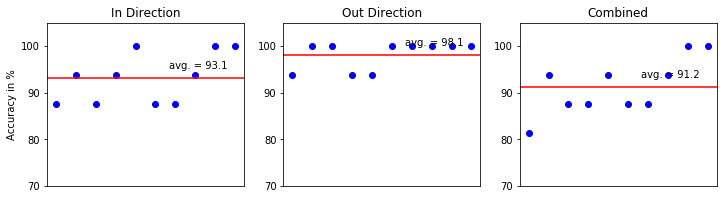



In-Accuracy:  0.93125
Out-Accuracy:  0.98125
Total-Accuracy:  0.9125


-----------------------

Confusion matrices of last loop


Confusion Matrix In-Direction:
    L  R
L  10  0
R   0  6
Accuracy In-Direction: 1.0


Confusion Matrix Out-Direction:
   L  R
L  7  0
R  0  9
Accuracy Out-Direction: 1.0


Confusion Matrix Combined:
    LL  LR  RL  RR
LL   4   0   0   0
LR   0   6   0   0
RL   0   0   3   0
RR   0   0   0   3
Total Accuracy: 1.0


In [50]:

clf = baseline_area_clf(area_percentage=0.50,total_area=1944, verbose=False)
accuracies = test_classifier(clf, tracks_ml, data_augmentation=False, n_bootstraps=10)

## 4.2 Baseline Zrotation Classifier

..........

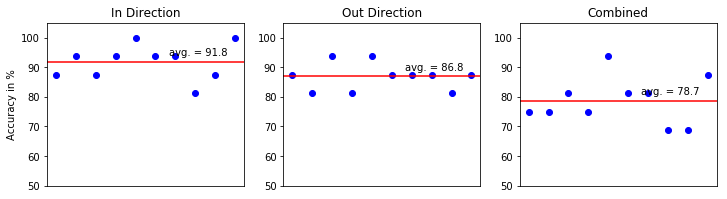



In-Accuracy:  0.91875
Out-Accuracy:  0.86875
Total-Accuracy:  0.7875


-----------------------

Confusion matrices of last loop


Confusion Matrix In-Direction:
   L  R
L  9  0
R  0  7
Accuracy In-Direction: 1.0


Confusion Matrix Out-Direction:
   L  R
L  6  1
R  1  8
Accuracy Out-Direction: 0.875


Confusion Matrix Combined:
    LL  LR  RL  RR
LL   1   1   0   0
LR   0   7   0   0
RL   0   0   5   0
RR   0   0   1   1
Total Accuracy: 0.875


In [26]:
clf = baseline_zrotation_clf(verbose=False)
accuracies = test_classifier(clf, tracks_ml, data_augmentation=False, n_bootstraps=10)

## 4.3 Logistic Regression

In [27]:
train_x, test_x = train_test_split(tracks_ml, test_size = 0.5, random_state=random.randint(0,2**32-1))

# get training labels
train_y = train_x[['in_direction','out_direction']]

# get training features
train_x = get_features(train_x)

# get test labels
test_y = test_x[['in_direction','out_direction']]

# get test features
test_x = get_features(test_x)

clf = logisic_regression_clf(k_features = 4, feature_selection_method="mutual_info_classif", normalized=False, verbose=True)

# train
clf.fit(train_x, train_y)

# test
clf.test(test_x, test_y)

Selected Features for in_direction: Index(['day_time', 'start_xpos', 'start_z_rotation', 'avg_zrotation'], dtype='object')
Selected Features for out_direction: Index(['end_xpos', 'end_ypos', 'end_z_rotation', 'avg_zrotation'], dtype='object')
Confusion Matrix In-Direction:
    L   R
L  16   1
R   3  11
Accuracy In-Direction: 0.8709677419354839


Confusion Matrix Out-Direction:
    L   R
L  18   0
R   1  12
Accuracy Out-Direction: 0.967741935483871


Confusion Matrix Combined:
    LL  LR  RL  RR
LL   8   0   1   0
LR   1   7   0   0
RL   1   0   8   0
RR   0   2   0   3
Total Accuracy: 0.8387096774193549


(0.8709677419354839, 0.967741935483871, 0.8387096774193549)

..........

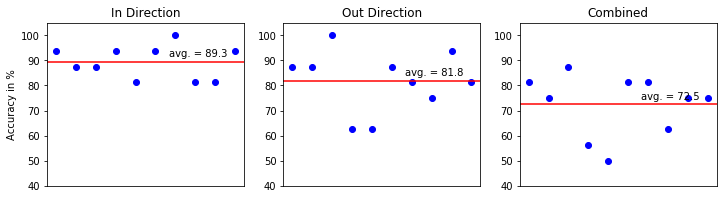



In-Accuracy:  0.89375
Out-Accuracy:  0.81875
Total-Accuracy:  0.725


-----------------------

Confusion matrices of last loop


Confusion Matrix In-Direction:
   L  R
L  9  0
R  1  6
Accuracy In-Direction: 0.9375


Confusion Matrix Out-Direction:
   L  R
L  5  2
R  1  8
Accuracy Out-Direction: 0.8125


Confusion Matrix Combined:
    LL  LR  RL  RR
LL   0   2   0   0
LR   0   7   0   0
RL   0   0   5   0
RR   0   1   1   0
Total Accuracy: 0.75


In [28]:
clf = logisic_regression_clf(k_features = 4, feature_selection_method="mutual_info_classif", normalized=False, verbose=False)
accuracies = test_classifier(clf, tracks_ml, n_bootstraps=10)

## 4.4 Random Forest

..........

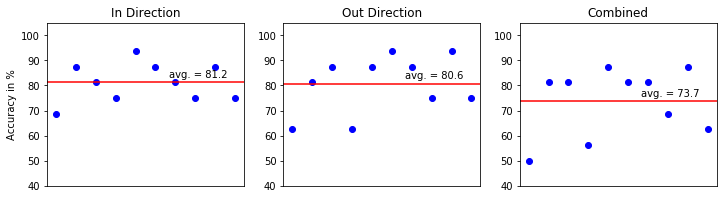



In-Accuracy:  0.8125
Out-Accuracy:  0.80625
Total-Accuracy:  0.7375


-----------------------

Confusion matrices of last loop


Confusion Matrix In-Direction:
   L  R
L  7  2
R  2  5
Accuracy In-Direction: 0.75


Confusion Matrix Out-Direction:
   L  R
L  4  4
R  0  8
Accuracy Out-Direction: 0.75


Confusion Matrix Combined:
    LL  LR  RL  RR
LL   1   1   1   1
LR   0   5   0   0
RL   0   1   2   1
RR   0   1   0   2
Total Accuracy: 0.625


In [29]:
clf = random_forest_clf(n_estimators = 32, max_depth=5, verbose=False)
accuracies = test_classifier(clf, tracks_ml)

..........

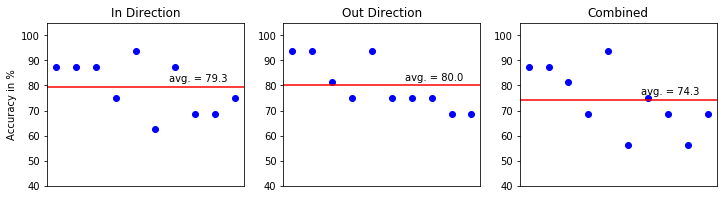



In-Accuracy:  0.79375
Out-Accuracy:  0.8
Total-Accuracy:  0.74375


-----------------------

Confusion matrices of last loop


Confusion Matrix In-Direction:
   L  R
L  9  2
R  2  3
Accuracy In-Direction: 0.75


Confusion Matrix Out-Direction:
   L  R
L  6  4
R  1  5
Accuracy Out-Direction: 0.6875


Confusion Matrix Combined:
    LL  LR  RL  RR
LL   3   1   0   2
LR   0   5   0   0
RL   0   1   3   0
RR   1   0   0   0
Total Accuracy: 0.6875


In [30]:
clf = random_forest_clf(n_estimators = 32, max_depth=10, verbose=False)
accuracies = test_classifier(clf, tracks_ml)

..........

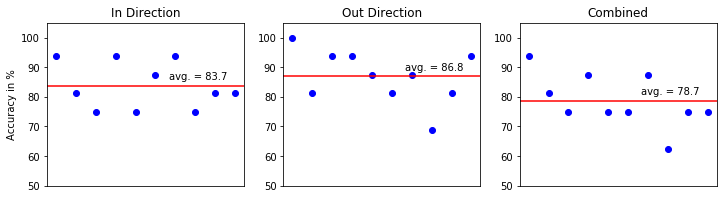



In-Accuracy:  0.8375
Out-Accuracy:  0.86875
Total-Accuracy:  0.7875


-----------------------

Confusion matrices of last loop


Confusion Matrix In-Direction:
   L  R
L  9  2
R  1  4
Accuracy In-Direction: 0.8125


Confusion Matrix Out-Direction:
   L  R
L  6  1
R  0  9
Accuracy Out-Direction: 0.9375


Confusion Matrix Combined:
    LL  LR  RL  RR
LL   1   1   2   0
LR   0   7   0   0
RL   0   0   3   0
RR   0   1   0   1
Total Accuracy: 0.75


In [32]:
clf = random_forest_clf(n_estimators = 1400, max_features='auto', max_depth=100, verbose=False)
accuracies = test_classifier(clf, tracks_ml)